# Rerandomisation

This notebook contains simulations to explore the implication of rerandomisation on statistical inference in randomised experiments.

## Setup

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import norm, ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
import copy

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})

## Single experiment example

Let's first start out by going through the steps for a single simulated experiment

### Simulate data

Let's simulate some data. We simulate an experiment with $n$ observations and $k$ covariates, all of which influence the outcome variable.

In [2]:
n = 5000
k = 10

In [3]:
x = np.random.normal(loc = 0, scale = 1, size = (n,k))

Let's now generate our outcome variable (under control). This is a linear function of the $k$ covariates, with the coefficients themselves uniformly distributed between -1 and 1. We also add on some normal noise.

In [4]:
beta = np.random.uniform(low = -1, high = 1, size = k)

In [5]:
eps = np.random.normal(loc = 0, scale = 0.25, size = n)

In [6]:
y = np.dot(x, beta) + eps

Check out the distribution of the outcome variable $y$:

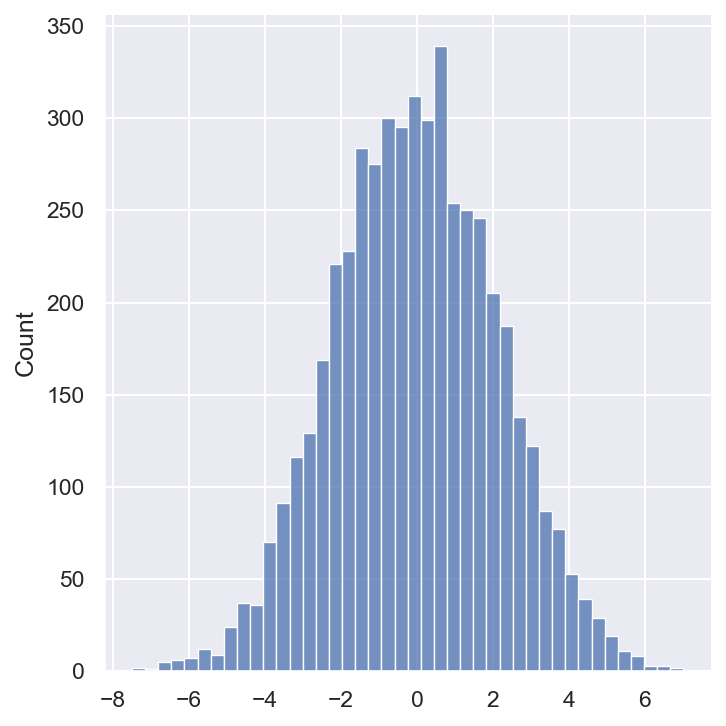

In [62]:
sns.displot(y)

### Assign treatment

Next I assume a 50/50 intervention with a single treatment arm.

In [8]:
t_p = np.random.uniform(low = 0, high = 1, size = n)
t = t_p > 0.5

I'll add on a hypothetical treatment effect of 1 unit to $y$.

In [9]:
y_obs = copy.deepcopy(y)
y_obs[t] = y[t] + 1

### Estimate treatment effect after single randomisation

Before looking at rerandomisation, let's estimate the treatment effect via linear regression. 

The true treatment effect is zero by construction. We will ignore the covariates in the estimation for now.

In [10]:
reg_dat = pd.DataFrame(data = {'y': y_obs, 't': t})
mod = smf.ols(formula = 'y ~ t', data = reg_dat)
res = mod.fit(cov_type='HC1')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     291.0
Date:                Sat, 19 Mar 2022   Prob (F-statistic):           1.81e-63
Time:                        18:21:55   Log-Likelihood:                -10915.
No. Observations:                5000   AIC:                         2.183e+04
Df Residuals:                    4998   BIC:                         2.185e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0541      0.042     -1.278      0.201      -0.137       0.029
t[T.True]      1.0364      0.061     17.059      0.000       0.917       1.155
==============================================================================
Omnibus:                        3.086   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                2.883
Skew:                          -0.001   Prob(JB):                        0.237
Kurtosis:                       2.882   Cond. No.                         2.61
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

### Calculate distance

As the first step towards rerandomisation, next we need to work out how dissimilar our treatment and control groups are in terms of their mean covariate values. Lets take the euclidian distance. For two $n$-dimensional vectors $x_0$ and $x_1$, this is defined as:

$$ d = \sqrt ( (x_0(1) - x_1(1))^2 + (x_0(2) - x_1(2))^2 + ... + (x_0(n) - x_1(n))^2) $$

In [11]:
x0 = x[~t]
x1 = x[t]
x0_bar = np.mean(x0, axis = 0)
x1_bar = np.mean(x1, axis = 0)

sq_devs = np.power(x0_bar - x1_bar, 2)
distance = np.sqrt(np.sum(sq_devs))
distance

0.09492011795376402

### Rerandomise until balance achieved

Lets now rerandomise until we achieve a fixed level of balance.

First, fix the criteria (tolerance) required for balance.

In [12]:
tol = 0.05

Now, rerandomise until that criteria is met:

In [13]:
max_reps = 1000

for i in range(max_reps):
    t_p = np.random.uniform(low = 0, high = 1, size = n)
    t = t_p > 0.5
    
    x0 = x[~t]
    x1 = x[t]
    x0_bar = np.mean(x0, axis = 0)
    x1_bar = np.mean(x1, axis = 0)

    sq_devs = np.power(x0_bar - x1_bar, 2)
    distance = np.sqrt(np.sum(sq_devs))
    if distance < tol:
        print(str(i) + " randomisations needed to achieve balance with tolerance " + str(tol))
        break


20 randomisations needed to achieve balance with tolerance 0.05


### Estimate treatment effect on rerandomised data

Finally, re-estimate the treatment effect using the assignment found via rerandomisation. Again, the true treatment effect is known as zero and we ignore covariates.

In [14]:
y_obs = copy.deepcopy(y)
y_obs[t] = y[t] + 1

reg_dat = pd.DataFrame(data = {'y': y_obs, 't': t})
mod = smf.ols(formula = 'y ~ t', data = reg_dat)
res = mod.fit(cov_type='HC1')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     294.0
Date:                Sat, 19 Mar 2022   Prob (F-statistic):           4.38e-64
Time:                        18:21:59   Log-Likelihood:                -10915.
No. Observations:                5000   AIC:                         2.183e+04
Df Residuals:                    4998   BIC:                         2.185e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0569      0.043     -1.332      0.183      -0.141       0.027
t[T.True]      1.0414      0.061     17.147      0.000       0.922       1.160
==============================================================================
Omnibus:                        3.119   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.911
Skew:                          -0.001   Prob(JB):                        0.233
Kurtosis:                       2.882   Cond. No.                         2.63
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

## Full simulation

The above was for a single experiment. To identify the effect of rerandomisation on average, let's follow the same process for a large number of simulated experiments. We can then inspect the estimated treatment effects and estimated standard errors.

Lets run the simulations, generating treatment effect estimates and estimated standard errors.

In [18]:
numsims = 1000
max_reps = 1000
ests = np.empty(shape = (numsims, 4))

for i in range(numsims):
    print ("sim " + str(i + 1) + " of " + str(numsims), end="\r")
    for j in range(max_reps):
        t_p = np.random.uniform(low = 0, high = 1, size = n)
        t = t_p > 0.5

        y_obs = copy.deepcopy(y)
        y_obs[t] = y[t] + 1
        
        # use first randomisation for baseline estimates
        if j == 0:
            reg_dat = pd.DataFrame(data = {'y': y_obs, 't': t})
            mod = smf.ols(formula = 'y ~ t', data = reg_dat)
            res = mod.fit(cov_type='HC1')
            ests[i, 0] = res.params[1]
            ests[i, 1] = res.HC1_se[1]            

        # calculate distance and rerandomise if needed
        x0 = x[~t]
        x1 = x[t]
        x0_bar = np.mean(x0, axis = 0)
        x1_bar = np.mean(x1, axis = 0)

        sq_devs = np.power(x0_bar - x1_bar, 2)
        distance = np.sqrt(np.sum(sq_devs))
            
        if distance < tol:
            reg_dat = pd.DataFrame(data = {'y': y_obs, 't': t})
            mod = smf.ols(formula = 'y ~ t', data = reg_dat)
            res = mod.fit(cov_type='HC1')
            ests[i, 2] = res.params[1]
            ests[i, 3] = res.HC1_se[1]
            break
        
        if (j == max_reps - 1):
            print("Did not achieve balance, adjust max_reps or tol")

In [19]:
ests_df = pd.DataFrame(ests, columns=['est_single', 'se_single', 'est_rerand', 'se_rerand'])
ests_df_wide = ests_df.melt()

Let's now take a look at the estimates, starting with the treatment effect estimates:

Text(0.5, 18.666666666666664, 'Estimated treatment effect')

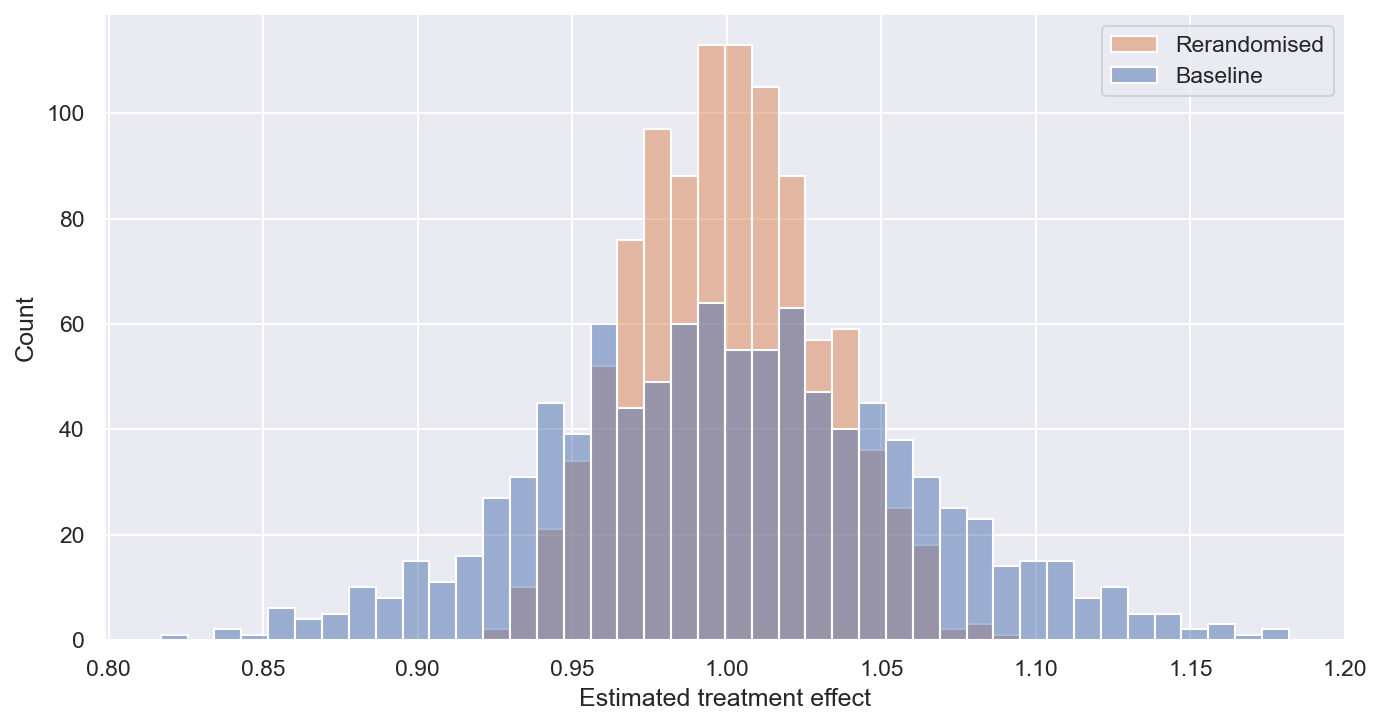

In [67]:
sns.displot(ests_df_wide.loc[ests_df_wide['variable'].isin(['est_single','est_rerand'])], 
            x = 'value', hue = 'variable', legend=False, hue_order = ['est_single', 'est_rerand'],
            height=5, aspect=15/8)
plt.legend(labels=["Rerandomised","Baseline"])
plt.xlabel("Estimated treatment effect")

The estimates are clearly tighter after re-randomisation.

Now let's look at the estimated standard errors:

Text(0.5, 18.666666666666664, 'Estimated standard error')

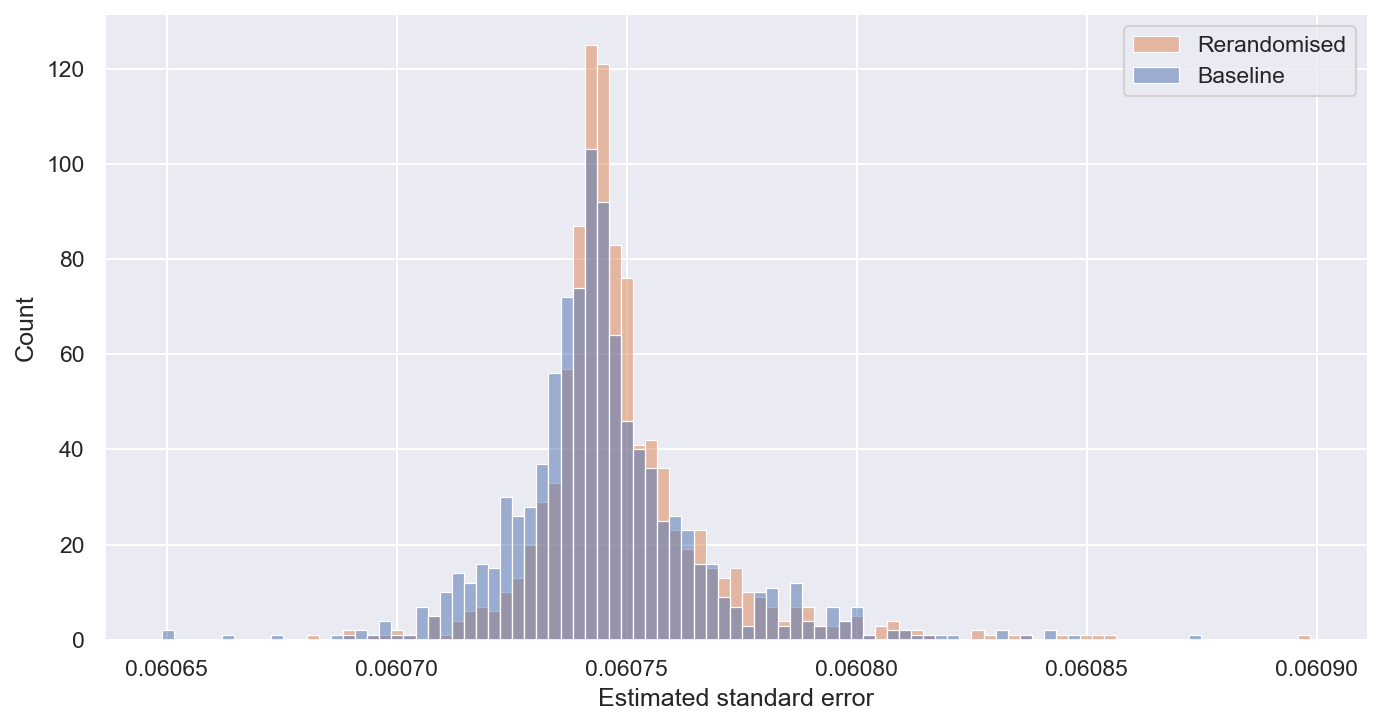

In [68]:
sns.displot(ests_df_wide.loc[ests_df_wide['variable'].isin(['se_single','se_rerand'])], 
                x = 'value', hue = 'variable', legend=False, hue_order = ['se_single','se_rerand'],
            height=5, aspect=15/8)
plt.legend(labels=["Rerandomised","Baseline"])
plt.xlabel("Estimated standard error")

The estimated standard errors in the rerandomised version are actually slightly higher (0.8%) than the standard version! Above we showed that the true standard errors are lower in the rerandomised version.

This is because the HC1 variance estimator uses within-group variance as to estimate the treatment effect variation. The balancing pushes this variance up!

In [24]:
print(ttest_ind(ests_df['se_single'], ests_df['se_rerand']))

print(100*(np.mean(ests_df['se_rerand'])/np.mean(ests_df['se_single']) - 1))

Ttest_indResult(statistic=-4.543186016110799, pvalue=5.871868149263075e-06)
0.006888596429077687



Now lets look at the t-statistics to get a better view of whether inference is valid. To do this, lets simulate again, but this time not add on any treatment effect. The t-statistics should be standard normal distributed.

In [26]:
t_stats = np.empty(shape = (numsims, 2))

for i in range(numsims):
    print ("sim " + str(i + 1) + " of " + str(numsims), end="\r")
    for j in range(max_reps):
        t_p = np.random.uniform(low = 0, high = 1, size = n)
        t = t_p > 0.5

        y_obs = copy.deepcopy(y)
        
        # use first randomisation for baseline estimates
        if j == 0:
            reg_dat = pd.DataFrame(data = {'y': y_obs, 't': t})
            mod = smf.ols(formula = 'y ~ t', data = reg_dat)
            res = mod.fit(cov_type='HC1')
            t_stats[i, 0] = res.params[1]/res.HC1_se[1]   

        # calculate distance and rerandomise if needed
        x0 = x[~t]
        x1 = x[t]
        x0_bar = np.mean(x0, axis = 0)
        x1_bar = np.mean(x1, axis = 0)

        sq_devs = np.power(x0_bar - x1_bar, 2)
        distance = np.sqrt(np.sum(sq_devs))
            
        if distance < tol:
            reg_dat = pd.DataFrame(data = {'y': y_obs, 't': t})
            mod = smf.ols(formula = 'y ~ t', data = reg_dat)
            res = mod.fit(cov_type='HC1')
            t_stats[i, 1] = res.params[1]/res.HC1_se[1]   

            break
        
        if (j == max_reps - 1):
            print("Did not achieve balance, adjust max_reps or tol")

Text(0.5, 18.666666666666664, 'T-value under null')

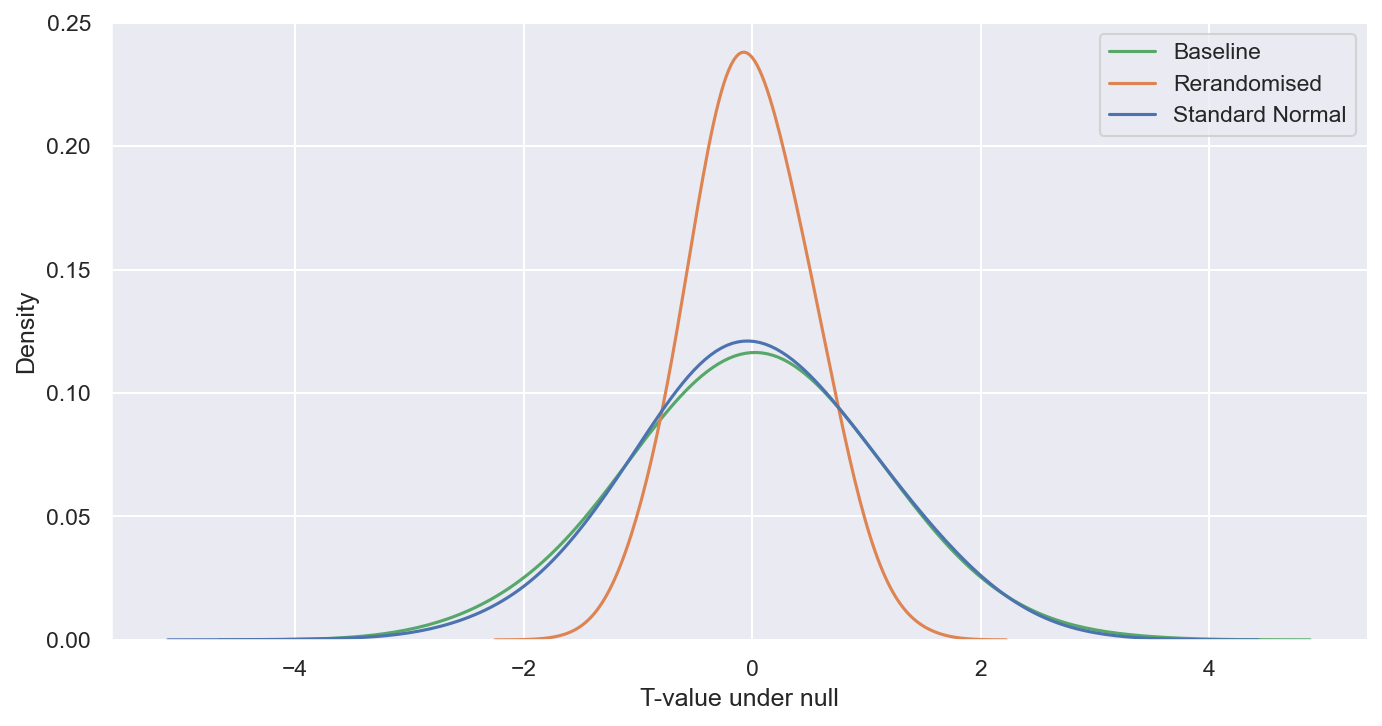

In [70]:
t_stats_df = pd.DataFrame(t_stats, columns=['t_single', 't_rerand'])
t_stats_df['standard_normal'] = np.random.normal(loc = 0, scale = 1, size = numsims)
t_stats_df_wide = t_stats_df.melt()
sns.displot(t_stats_df_wide, x = 'value', hue = 'variable', kind = 'kde', bw_adjust = 2, legend = False,
            height=5, aspect=15/8)
plt.legend(labels=["Baseline", "Rerandomised", "Standard Normal"])
plt.xlabel("T-value under null")

So while the treatment effect estimates are more precise, this is not reflected in the estimated standard errors so a naive inference approach is no longer valid. 